# Table Detection Using Table Transformer
This notebook illustrates table detection using the `microsoft-table-transformer` model on a tricky PDF file

⚠ You will have to restart the session in Colab after installing python dependencies ⚠

In [1]:
#@title Install System Dependencies
!apt update
!apt install -qq -y poppler-utils

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [713 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,874 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.6 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,505 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,073 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy 

In [2]:
#@title Install Python Dependencies
!pip install transformers hf-transfer timm pdf2image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.6 MB/s eta 0:00:00


In [3]:
#@title Set Environment Variables
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [4]:
#@title Download Test File
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="DataForGood/taxobservatory-pdfs", repo_type="dataset", filename="Acciona_2020_CbCR_1.pdf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Acciona_2020_CbCR_1.pdf:   0%|          | 0.00/78.8k [00:00<?, ?B/s]

In [5]:
#@title Convert PDF to Images
import tempfile
import pdf2image

temp_dir = tempfile.mkdtemp()
image_paths = pdf2image.convert_from_path(
    file_path,
    dpi=300,
    output_folder=temp_dir,
    paths_only=True
)

In [6]:
#@title Plotting Functions
import pprint
from matplotlib import pyplot as plt
from PIL import Image

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: Th

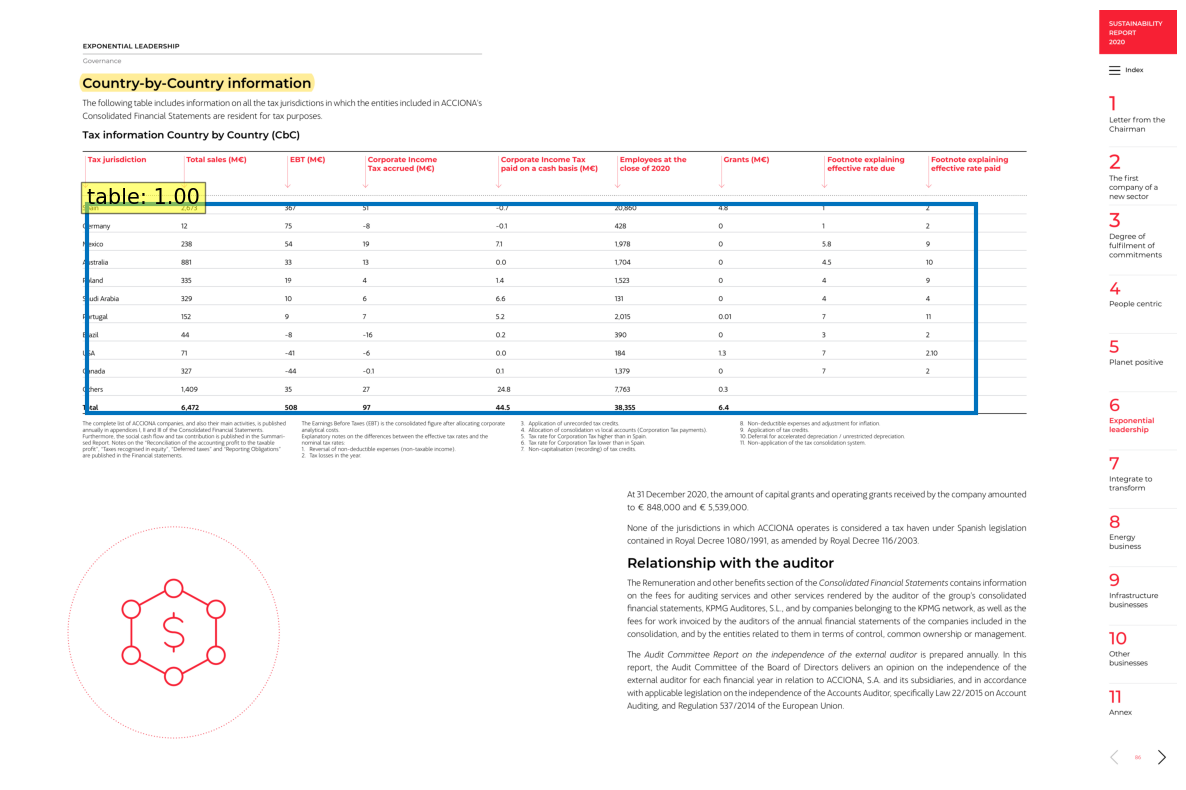

In [7]:
#@title Analyze Layout (Table Transformer)
import torch
from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

pages = []
for i, path in enumerate(image_paths):
  with Image.open(path) as image:
      feature_extractor = DetrFeatureExtractor()
      encoding = feature_extractor(image, return_tensors="pt")

      with torch.no_grad():
        outputs = model(**encoding)

      width, height = image.size
      results = feature_extractor.post_process_object_detection(outputs, threshold=0.5, target_sizes=[(height, width)])[0]

      pages.append((image, results))

for image, results in pages:
  plot_results(image, results['scores'], results['labels'], results['boxes'])
